In [78]:
import torch
import torchvision
import matplotlib.pyplot as plt
import pennylane as qml
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

# MNIST Model

## Data Preprocessing

In [2]:
# Load data from MNIST dataset 
training_data = torchvision.datasets.MNIST("root", train=True, download=True, transform=ToTensor())
testing_data = torchvision.datasets.MNIST("root", train=False, download=True, transform=ToTensor())

In [3]:
# Only do 0's and 1's
#training_data.data = training_data.data[training_data.targets<=1]
#training_data.targets = training_data.targets[training_data.targets<=1]

In [4]:
# Display information on datasets
print("Training data size:\t ", training_data.data.size())
print("Testing data size:\t ", testing_data.data.size())

Training data size:	  torch.Size([60000, 28, 28])
Testing data size:	  torch.Size([10000, 28, 28])


Text(0.5, 1.0, '5')

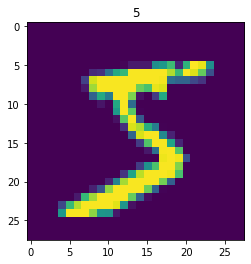

In [5]:
# Display a sample
plt.imshow(training_data.data[0])
plt.title('%i' % training_data.targets[0])

In [6]:
# Prepare subset of data and shuffle
train_dataloader = DataLoader(training_data, batch_size = 1000, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size = 100, shuffle=True)

In [11]:
# Showcase dataloader information
for batch, (images, labels) in enumerate(train_dataloader): 
    print(batch)
    print(images.size())
    print(images.view(images.shape[0], -1).size())
    print(labels.size())
    break

0
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 784])
torch.Size([1000])


In [12]:
test = torch.nn.functional.one_hot(training_data.targets)
print(test[0])

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])


## Network Design and Parameters

In [32]:
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface='torch')
def qnode(inputs, w0, w1, w2, w3):
    qml.RX(inputs[0], wires=0)
    qml.RX(inputs[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.Rot(*w0, wires=0)
    qml.Rot(*w1, wires=1)
    qml.RY(w2, wires=0)
    qml.RY(w3, wires=1)
    qml.CNOT(wires=[0, 1])
    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1))

weight_shapes = {"w0": 3, "w1": 3, "w2": 1, "w3": 1}
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

qlayer(torch.Tensor([1,2]))

tensor([-0.1052, -0.3478], grad_fn=<ToCopyBackward0>)

In [108]:
# Define neural network 
# Great source: https://pennylane.ai/qml/demos/tutorial_qnn_module_torch.html
# Note that in_channels = 1 because the input is a grayscale image
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.main = nn.Sequential(
            nn.Linear(in_features=784, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=10),
            nn.LogSoftmax(dim=1)
        )
        
        self.final = nn.Sequential(nn.Linear(in_features=10, out_features=10))
    

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.main(x)
        x_split = torch.split(x, 2, dim=1)
        x_split = list(x_split)
        for i in range(len(x_split)): 
            x_split[i] = qlayer(x_split[i])
        x = torch.cat(x_split, dim=1)
        x = self.final(x)
        return x

In [109]:
# View neural network 
network = Net()
print(network)

Net(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
  (final): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
  )
)


In [110]:
from torchsummary import summary
summary(network, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
              ReLU-2                  [-1, 128]               0
            Linear-3                   [-1, 64]           8,256
              ReLU-4                   [-1, 64]               0
            Linear-5                   [-1, 10]             650
        LogSoftmax-6                   [-1, 10]               0
            Linear-7                   [-1, 10]             110
Total params: 109,496
Trainable params: 109,496
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.42
Estimated Total Size (MB): 0.42
----------------------------------------------------------------


## Training the Model

In [111]:
# Define training routine
def train(epochs):
    epoch_list = []
    accuracy_list = []
    loss_list = []
    for epoch in range(1, epochs+1):
        accuracy = 0
        running_loss = 0

        for batch_idx, (image, labels) in enumerate(train_dataloader):
            output = network(image)                           # Find network output
            loss = loss_function(output, labels)              # Compute loss

            predicted = torch.max(output.data, 1)[1]          # Find predicted value
            batch_corr = (predicted == labels).sum()          # Find number of correct values
            batch_accuracy = (100*batch_corr / len(labels))    
            accuracy+=batch_accuracy/60
            running_loss += loss.item()

            optimizer.zero_grad()                             # Clear gradients for this training step
            loss.backward()                                   # Compute gradients from backpropagation 
            optimizer.step()                                  # Apply changes from gradients
            print("Batch accuracy: %.2f" % batch_accuracy)

        print("Training accuracy: %.2f \t Training loss: %.2f " % (accuracy, running_loss))
        epoch_list.append(epoch)
        accuracy_list.append(accuracy)
        loss_list.append(running_loss)
    return epoch_list, accuracy_list, loss_list
        

In [112]:
# Run training
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr=0.01)
epochs, accuracy, loss = train(epochs=10)

Batch accuracy: 10.70
Batch accuracy: 13.20
Batch accuracy: 16.60
Batch accuracy: 13.60
Batch accuracy: 21.20
Batch accuracy: 30.00
Batch accuracy: 29.70
Batch accuracy: 28.40
Batch accuracy: 34.60
Batch accuracy: 36.00
Batch accuracy: 40.80
Batch accuracy: 40.30
Batch accuracy: 43.50
Batch accuracy: 44.80
Batch accuracy: 49.00
Batch accuracy: 51.10
Batch accuracy: 56.80
Batch accuracy: 52.00
Batch accuracy: 55.50
Batch accuracy: 55.40
Batch accuracy: 55.80
Batch accuracy: 57.50
Batch accuracy: 61.30
Batch accuracy: 61.60
Batch accuracy: 63.00
Batch accuracy: 62.30


KeyboardInterrupt: 

In [105]:
# Run training
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr=0.01)
epochs, accuracy, loss = train(epochs=10)

Batch accuracy: 8.30
Batch accuracy: 29.40
Batch accuracy: 33.30
Batch accuracy: 35.10
Batch accuracy: 40.30
Batch accuracy: 38.00
Batch accuracy: 44.10
Batch accuracy: 52.90
Batch accuracy: 49.70
Batch accuracy: 53.30
Batch accuracy: 54.20
Batch accuracy: 53.10
Batch accuracy: 57.40
Batch accuracy: 58.90
Batch accuracy: 57.90
Batch accuracy: 60.70
Batch accuracy: 60.90
Batch accuracy: 67.80
Batch accuracy: 67.70
Batch accuracy: 65.40
Batch accuracy: 64.50
Batch accuracy: 69.30
Batch accuracy: 69.60
Batch accuracy: 69.40
Batch accuracy: 72.70
Batch accuracy: 75.10
Batch accuracy: 70.70
Batch accuracy: 74.00
Batch accuracy: 71.60
Batch accuracy: 73.20
Batch accuracy: 77.50
Batch accuracy: 77.20
Batch accuracy: 76.00
Batch accuracy: 78.30
Batch accuracy: 78.40
Batch accuracy: 79.60
Batch accuracy: 77.20
Batch accuracy: 78.60
Batch accuracy: 80.80
Batch accuracy: 82.90
Batch accuracy: 82.30
Batch accuracy: 79.80
Batch accuracy: 83.30
Batch accuracy: 82.20
Batch accuracy: 83.40
Batch accur

Batch accuracy: 96.00
Batch accuracy: 96.30
Batch accuracy: 95.80
Batch accuracy: 96.10
Batch accuracy: 97.60
Batch accuracy: 97.10
Batch accuracy: 97.30
Batch accuracy: 96.90
Batch accuracy: 97.50
Batch accuracy: 96.50
Batch accuracy: 97.60
Batch accuracy: 96.30
Batch accuracy: 97.70
Batch accuracy: 96.70
Batch accuracy: 96.40
Batch accuracy: 96.90
Batch accuracy: 96.70
Batch accuracy: 96.70
Batch accuracy: 97.00
Batch accuracy: 96.70
Batch accuracy: 96.20
Batch accuracy: 97.10
Batch accuracy: 97.30
Batch accuracy: 96.60
Batch accuracy: 98.00
Batch accuracy: 95.90
Batch accuracy: 96.40
Batch accuracy: 95.50
Batch accuracy: 96.80
Batch accuracy: 96.70
Batch accuracy: 97.00
Batch accuracy: 96.70
Batch accuracy: 96.40
Batch accuracy: 97.90
Batch accuracy: 96.70
Batch accuracy: 97.00
Batch accuracy: 97.20
Batch accuracy: 97.10
Batch accuracy: 96.20
Batch accuracy: 96.90
Batch accuracy: 97.00
Batch accuracy: 97.20
Batch accuracy: 96.90
Batch accuracy: 96.40
Batch accuracy: 97.20
Batch accu

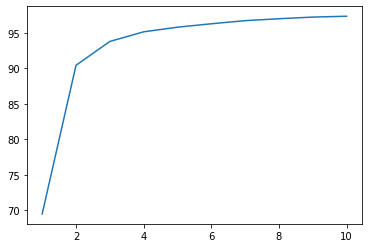

In [107]:
plt.plot(epochs, accuracy)

In [ ]:
plt.plot(epochs, accuracy)

## Testing the Model

In [ ]:
def test(): 
    accuracy = 0
    with torch.no_grad(): 
        for image, labels in enumerate(test_dataloader): 
            output = network(image)
            predicted = torch.max(output.data, 1)[1]
            accuracy += (100*(predicted == labels).sum() / len(labels))
    print("Accuracy: ", accuracy)

In [ ]:
test()

# Network Class

In [ ]:
class NN: 

In [19]:
train_losses = []
train_counter = [] 
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [26]:
log_interval = 10

def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), '/results/model.pth')
            torch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [27]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [28]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

C:\Users\Andrew Hayman\AppData\Local\Temp\ipykernel_520\161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3063, Accuracy: 1377/10000 (14%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312027


FileNotFoundError: [Errno 2] No such file or directory: '/results/model.pth'